<a href="https://colab.research.google.com/github/finfrierson/data-science-fundamentals/blob/main/Fin_FrieU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup and Intro

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

In [2]:
mortality = pd.read_csv('https://raw.githubusercontent.com/finfrierson/data-science-fundamentals/refs/heads/main/Life-Expectancy-Data-Averaged.csv')

In [3]:
mortality

,Country,Region,Year,Infant_deaths,Under_five_deaths,Adult_mortality,Alcohol_consumption,Hepatitis_B,Measles,BMI,Polio,Diphtheria,Incidents_HIV,GDP_per_capita,Population_mln,Thinness_ten_nineteen_years,Thinness_five_nine_years,Schooling,Economy_status,Life_expectancy
0,Afghanistan,Asia,2007.5,71.08125,98.61250,265.804969,0.016125,64.5625,24.3750,22.46250,55.3750,55.1250,0.022500,408.5625,27.450625,16.58125,15.58125,2.90000,1.0,59.65625
1,Albania,Rest of Europe,2007.5,15.25625,17.14375,83.132969,4.696875,98.0000,95.9375,25.85625,98.1250,98.0625,0.025625,3071.1250,2.969375,1.61875,1.70000,9.24375,1.0,75.95000
2,Algeria,Africa,2007.5,26.75625,31.19375,113.439281,0.400625,88.3125,93.2500,24.86875,91.7500,91.8750,0.021875,3745.1250,34.820625,6.09375,5.97500,6.99375,1.0,73.78750
3,Angola,Africa,2007.5,88.76875,144.16250,297.844063,4.935625,68.8125,64.0000,22.51875,35.7500,55.5625,1.303750,2647.8125,21.623750,6.19375,6.66875,4.60625,1.0,52.82500
4,Antigua and Barbuda,Central America and Caribbean,2007.5,9.47500,11.51875,142.478813,7.755000,98.2500,75.4375,25.85000,96.9375,98.3125,0.125000,14678.7500,0.085000,3.42500,3.37500,9.01875,1.0,75.35000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,"Venezuela, RB",South America,2007.5,15.85000,18.50000,151.056156,7.458125,72.4375,83.0000,26.49375,79.1875,75.2500,0.400000,9294.8750,27.392500,1.65000,1.56250,8.23750,1.0,72.79375
175,Vietnam,Asia,2007.5,19.50000,24.47500,133.054406,1.742500,87.4375,65.0000,20.76250,94.9375,91.7500,0.196875,1807.8750,86.032500,14.92500,15.62500,6.90000,1.0,74.33125
176,"Yemen, Rep.",Middle East,2007.5,52.44375,69.57500,239.653938,0.047000,60.1875,95.0000,23.02500,71.6250,72.6250,0.025000,2406.8125,21.730625,13.83125,13.75000,2.22500,1.0,64.16250
177,Zambia,Africa,2007.5,60.58125,99.20625,452.761219,2.903125,82.8750,39.1875,22.00000,82.9375,83.8125,6.868125,1059.8750,12.862500,6.88125,6.76250,6.43750,1.0,52.33125


In my project, I used a data set that measured various life statitics in different countries, like life expectancy, alcohol consumption, prevelance of various diseases, percent of underweight people, and more. I chose to compare the average number of deaths of children under five per 1000 live births to the per capita alcohol consumption in liters of pure alcohol. One note about all my models: I have alcohol consumption on the y-axis instead of x-axis. I didn't realize until after making all my models, but the trends are still the same so I left it.

Text(0, 0.5, 'Alcohol Consumed (pure L)')

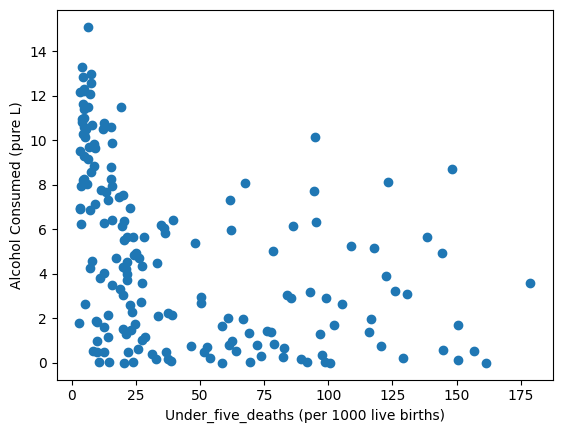

In [4]:
plt.scatter(mortality['Under_five_deaths'], mortality['Alcohol_consumption'])

plt.xlabel("Under_five_deaths (per 1000 live births)")
plt.ylabel("Alcohol Consumed (pure L)")

#Model 1

As this was my first attempt, I didn't really know what I was doing. I ended up usng an inverse in the linear portion of my model, as that matches up with what the scatterplot I graphed initially shows.

In [ ]:
#Creating the model
with pm.Model() as mortality_model:
    #prior for the linear part of the model
    β = pm.Normal("β", mu=0, sigma=10)
  #linear part
    μ = pm.Deterministic("μ", β *1/mortality['Under_five_deaths'])

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=mortality['Alcohol_consumption'])
#generate data
    idata_mortality = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_mortality, model=mortality_model,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Alcohol Consumed')

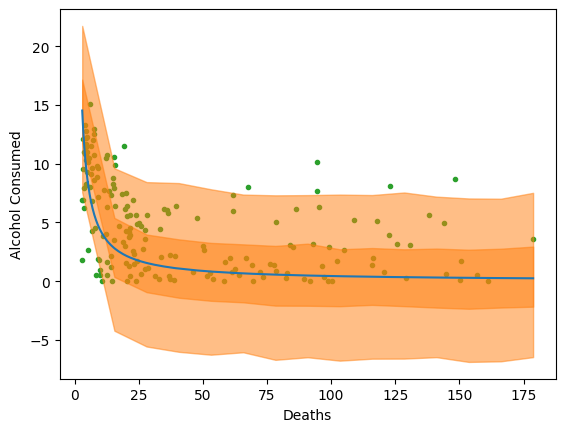

In [ ]:

#plots the posterior predictive distribution

#line of best fit formula
mean_line = idata_mortality.posterior["μ"].mean(("chain", "draw"))

#generates values for formula
deaths = np.random.normal(mortality['Under_five_deaths'].values, 0.01)
idx = np.argsort(deaths)
x = np.linspace(deaths.min(), deaths.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_mortality.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(deaths[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plotting
_, ax = plt.subplots()
ax.plot(mortality['Under_five_deaths'], mortality['Alcohol_consumption'], "C2.", zorder=-3)
ax.plot(mortality['Under_five_deaths'][idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("Deaths")
ax.set_ylabel("Alcohol Consumed")

<Axes: xlabel='y_pred'>

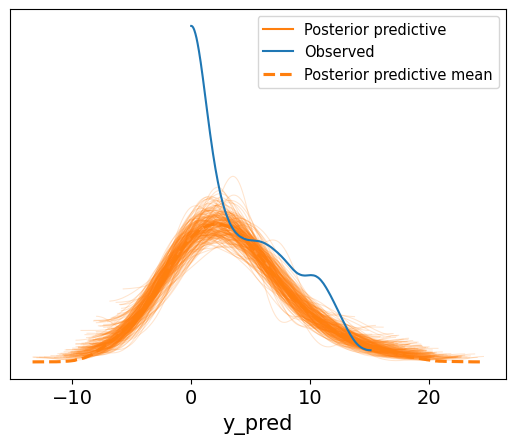

In [ ]:
az.plot_ppc(idata_mortality, num_pp_samples=200, colors=["C1", "C0", "C1"])

Here I plotted the model and found that overall, this model is terrible. It has a pretty standard bell curve centered near 0 and graphs negative values and is almost entierly an underestimate from the observed data. Additionally, the beginning behavior is very different from observed data.

#Model 2

Because of the failures of the last model, I decided to try a neative binomial model. This would get rid of the problem of negative values, and I can go from there on what to alter for a better fit. I will stick with the iverse I previously used in the linear section.

In [ ]:
with pm.Model() as mortality_model_2:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)
    #linear
    μ = pm.Deterministic("μ", α + β * 1/mortality['Under_five_deaths'])

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 10)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=mortality['Alcohol_consumption'])
    #data
    idata_mortality_2 = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_mortality_2, model = mortality_model_2, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Alcohol consumed')

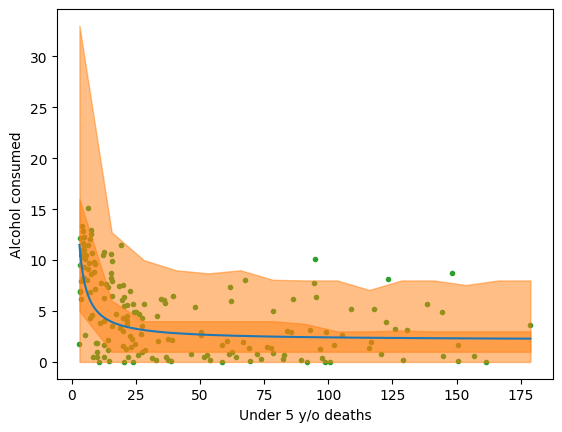

In [ ]:
#Graphing the model
mean_line = idata_mortality_2.posterior["μ"].mean(("chain", "draw"))
ds = np.random.normal(mortality['Under_five_deaths'].values, 0.01)
idx = np.argsort(ds)
x = np.linspace(ds.min(), ds.max(), 15)
y_pred_q = idata_mortality_2.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(ds[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(mortality['Under_five_deaths'], mortality['Alcohol_consumption'], "C2.", zorder=-3)
ax.plot(mortality['Under_five_deaths'][idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Under 5 y/o deaths")
ax.set_ylabel("Alcohol consumed")

<Axes: xlabel='y_pred'>

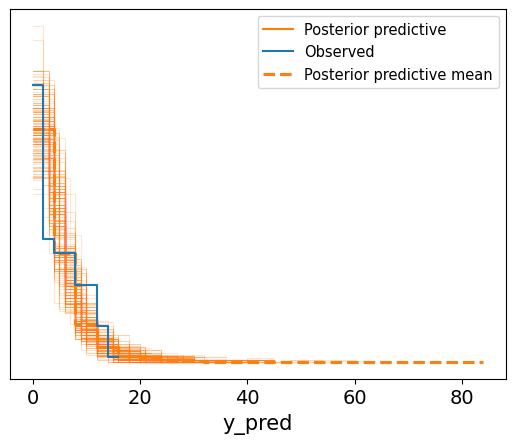

In [ ]:
az.plot_ppc(idata_mortality_2, num_pp_samples=200, colors=["C1", "C0", "C1"])

 Model 2 is more acurate, with no negative values and the data matching up reasonably with the observed data. However, there were some struggles with too extreme of values at the beginning of the graph (For example stretching all the way up to nearly 35 with the high HDI) This model is definitely an improvement though, so to reduce the extremity of predictions I will use an inverse square root (1/sqrtx) in the same negative binomial model, that way values at the beginning and end are less likely to become extreme.

#Model 3

In [ ]:
with pm.Model() as mortality_model_3:

    #priors for the linear part of the model
    α = pm.Normal("α", mu=0, sigma=10)
    β = pm.Normal("β", mu=0, sigma=10)
    #linear
    μ = pm.Deterministic("μ", α + β * 1/pm.math.sqrt(mortality['Under_five_deaths']))

    #prior for the likelihood's standard deviation
    σ = pm.HalfNormal("σ", 5)

    #likelihood
    y_pred = pm.NegativeBinomial("y_pred", mu=μ, alpha=σ, observed=mortality['Alcohol_consumption'])

    idata_mortality_3 = pm.sample()

Output()

Output()

In [ ]:
pm.sample_posterior_predictive(idata_mortality_3, model = mortality_model_3, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'Alcohol consumed')

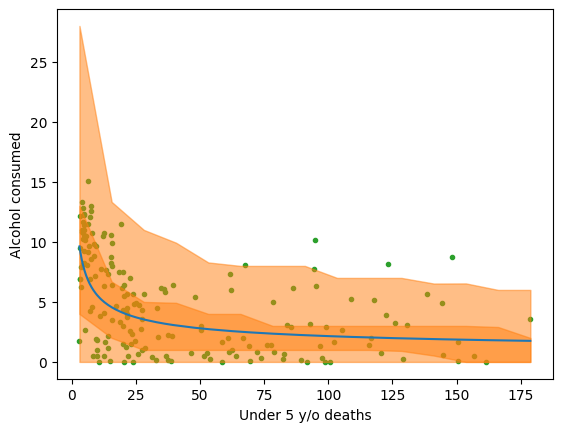

In [ ]:
#Graphing the model
mean_line = idata_mortality_3.posterior["μ"].mean(("chain", "draw"))
ds = np.random.normal(mortality['Under_five_deaths'].values, 0.01)
idx = np.argsort(ds)
x = np.linspace(ds.min(), ds.max(), 15)
y_pred_q = idata_mortality_3.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(ds[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

_, ax = plt.subplots()
ax.plot(mortality['Under_five_deaths'], mortality['Alcohol_consumption'], "C2.", zorder=-3)
ax.plot(mortality['Under_five_deaths'][idx], mean_line[idx], c="C0")

for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

ax.set_xlabel("Under 5 y/o deaths")
ax.set_ylabel("Alcohol consumed")

<Axes: xlabel='y_pred'>

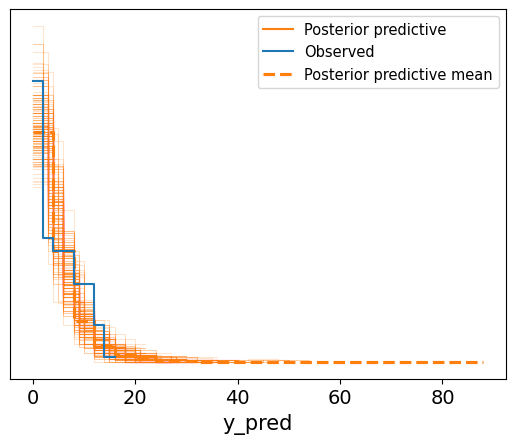

In [ ]:
az.plot_ppc(idata_mortality_3, num_pp_samples=200, colors=["C1", "C0", "C1"])

After adding a square root to the inverse I normally use, the model is looking pretty good. The graphed model is quite good, with a more accurate decreasing trend. The initial spike has also been reduced to a far more reasonable amount.Additionally, the posterior predictive check looks alright (Admittedly I don't really know how to graph closer to what is seen in the observed, But I try to make my trend fit a smoother line through the observed values).

#Conclusion

From my models, you can see the inverse relation between the amount of alcohol and amount of deaths, meaning the more average alcohol drunk the lower the amount of deaths tends to be. This is almost certainly attributed to the fact that alcohol is expensive which means only more developed/richer countries will have it, and those types of countries will tend to have better medical equipment/child care. I still do not know if there was much significance to the values with unexpectedly high alcohol consumption, as they caused the trent to not be a super clear inverse trend, but I think my overall model had an accurate fit.